<a href="https://colab.research.google.com/github/kishore-n-george/telecom-churn/blob/main/telecom_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn
## Objectives
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

Recommend strategies to manage customer churn based on your observations.



Re-Usable Functions

In [1]:
def calculate_metrics(train,pred):
  """ Calculates important metrics for a given train and predictions"""
  metrics=[]
  r2 = r2_score(train, pred)
  metrics.append(r2)
  print("R2 Score is:", r2)
  rss = np.sum(np.square(train - pred))
  metrics.append(rss)
  print("RSS is ", rss)
  mse = mean_squared_error(train, pred)
  metrics.append(mse)
  print("MSE is: ", mse)
  # Root Mean Squared Error
  rmse = mse**0.5
  metrics.append(rmse)
  print("RMSE is: ", rmse)
  return metrics

def run_cross_validation():
  """ Runs Cross validation for Ridge"""
  params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                      2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

  ridge = Ridge()
  # cross validation
  ridgeCV = GridSearchCV(estimator = ridge, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error',  
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1, n_jobs=-1)            
  ridgeCV.fit(X_train, y_train) 

  print(ridgeCV.best_params_)
  return ridgeCV

def do_residual_analysis(y_train, y_train_pred):
  """Does residual analysis and plots residuals"""
  y_res = y_train - y_train_pred
  #y_res
  data = pd.DataFrame({"res":y_res})
  plt.scatter( y_train_pred , data['res'])
  plt.axhline(y=0, color='r', linestyle=':')
  plt.xlabel("Predictions")
  plt.ylabel("Residual")
  plt.show()

# Distribution of errors
  p = sns.distplot(y_res,kde=True)

  p = plt.title('Normality of error terms/residuals')
  plt.xlabel("Residuals")
  plt.show()

def print_metrics(ridge_metrics, lasso_metrics, col1, col2):
  """Print metrics in comparable tabular format"""
  ## Setting float display options
  pd.options.display.float_format = "{:,.2f}".format
  # Creating a table which contain all the metrics
  lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                        'MSE (Train)', 'RMSE (Train)', 'R2 Score (Test)','RSS (Test)',
                        'MSE (Test)', 'RMSE (Test)'],
              col1 : ridge_metrics,
              col2 : lasso_metrics }

  final_metric = pd.DataFrame(lr_table, columns = ['Metric', col1,col2] )
  final_metric.set_index('Metric')
  print(final_metric)

# Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [46]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [47]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Loading Data

In [48]:
telecom = pd.read_csv("train.csv")

In [49]:
# Check the head of the dataset
telecom.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...          0.0          0.0        NaN        NaN        NaN   
1  122.787  ...          0.0          0.0        NaN        1.0        NaN   
2  103.176  ...          0.0          0.0        NaN        NaN        NaN   
3  205.260  ...          0.0          0.0        NaN        NaN        NaN   
4  128.191  ...          1.0          0.0        1.0        1.0        1.0   

      aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958.0         0.0         0.0         0.0                0.0  
1   710.0         0.0         0.0         0.0                0.0  
2   882.0         0.0         0.0         0.0                0.0  
3   982.0         0.0         0.0         0.0                0.0  
4   647.0         0.0         0.0         0.0                0.0  

[5 rows x 172 columns]

Inspect the various aspects of the dataframe

In [50]:
telecom.shape
# Inference - 34897 Rows, 172 Columns

(34897, 172)

In [51]:
telecom.info(verbose=True, show_counts=True)
# Inference - some columns with null values.
# Data prep needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        34897 non-null  int64  
 1    circle_id                 34897 non-null  int64  
 2    loc_og_t2o_mou            34551 non-null  float64
 3    std_og_t2o_mou            34551 non-null  float64
 4    loc_ic_t2o_mou            34551 non-null  float64
 5    last_date_of_month_6      34897 non-null  object 
 6    last_date_of_month_7      34703 non-null  object 
 7    last_date_of_month_8      34539 non-null  object 
 8    arpu_6                    34897 non-null  float64
 9    arpu_7                    34897 non-null  float64
 10   arpu_8                    34897 non-null  float64
 11   onnet_mou_6               33510 non-null  float64
 12   onnet_mou_7               33575 non-null  float64
 13   onnet_mou_8               33044 non-null  fl

In [56]:
rech_col = [col for col in telecom.columns if 'rech' in col]

0        NaN
1        NaN
2        NaN
3        NaN
4        7.0
        ... 
34892    NaN
34893    5.0
34894    1.0
34895    NaN
34896    NaN
Name: total_rech_data_6, Length: 34897, dtype: float64

Check for duplicates

In [12]:
# check for duplicate rows based on id
any_duplicates=telecom.duplicated(['id']).any()
print(any_duplicates)
# no duplicate records found

False


Remove Empty columns

In [13]:
# remove empty columns
telecom = telecom.dropna(axis = 1, how = 'all')
telecom.info(verbose=True, show_counts=True)

# no columns dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        34897 non-null  int64  
 1    circle_id                 34897 non-null  int64  
 2    loc_og_t2o_mou            34551 non-null  float64
 3    std_og_t2o_mou            34551 non-null  float64
 4    loc_ic_t2o_mou            34551 non-null  float64
 5    last_date_of_month_6      34897 non-null  object 
 6    last_date_of_month_7      34703 non-null  object 
 7    last_date_of_month_8      34539 non-null  object 
 8    arpu_6                    34897 non-null  float64
 9    arpu_7                    34897 non-null  float64
 10   arpu_8                    34897 non-null  float64
 11   onnet_mou_6               33510 non-null  float64
 12   onnet_mou_7               33575 non-null  float64
 13   onnet_mou_8               33044 non-null  fl

Drop rows with NA

In [14]:
#drop all the rows with only nan values
telecom = telecom.dropna(axis = 0, how = 'all')
telecom.info()
# no of rows remains 34897

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Columns: 172 entries, id to churn_probability
dtypes: float64(152), int64(11), object(9)
memory usage: 45.8+ MB


Drop columns that high percentage of Nan

In [15]:
#drop columns that have high percentage of nan
print(telecom.shape)
# keep columns where null percentage is less than 60%
telecom = telecom.loc[:, telecom.isnull().mean() < .6]
# 30 columns with high percentage of nulls dropped
print(telecom.shape)

(34897, 172)
(34897, 142)


Drop rows with high percentage of Nan

In [17]:
# drop rows that have high percentage of nan
perc = 60.0 
# calculates minimun number of columns without null value to reach 60%
min_count =  int(((100-perc)/100)*telecom.shape[1] + 1)
#atleast 31 columns should be non na
print(min_count)
telecom = telecom.dropna( axis=0, 
                    thresh=min_count)
telecom.shape
# 374 rows dropped.

57


(34523, 142)

Data Manipulation

In [18]:
telecom.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34523 entries, 0 to 34896
Data columns (total 142 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    34523 non-null  int64  
 1    circle_id             34523 non-null  int64  
 2    loc_og_t2o_mou        34523 non-null  float64
 3    std_og_t2o_mou        34523 non-null  float64
 4    loc_ic_t2o_mou        34523 non-null  float64
 5    last_date_of_month_6  34523 non-null  object 
 6    last_date_of_month_7  34433 non-null  object 
 7    last_date_of_month_8  34282 non-null  object 
 8    arpu_6                34523 non-null  float64
 9    arpu_7                34523 non-null  float64
 10   arpu_8                34523 non-null  float64
 11   onnet_mou_6           33510 non-null  float64
 12   onnet_mou_7           33575 non-null  float64
 13   onnet_mou_8           33044 non-null  float64
 14   offnet_mou_6          33510 non-null  float64
 15   

Print all columns with missing values

In [20]:
def print_cols_with_missing_values():
  pd.set_option('display.max_rows', None)
  cols_with_missing_values = telecom.isnull().sum().sort_values(ascending=False)
  display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                      columns=["Number of Missing Values"]))
  pd.reset_option('display.max_rows')

print_cols_with_missing_values()

Number of Missing Values
spl_og_mou_8                              1479
og_others_8                               1479
loc_og_t2c_mou_8                          1479
loc_og_mou_8                              1479
loc_og_t2t_mou_8                          1479
std_og_t2t_mou_8                          1479
std_og_t2m_mou_8                          1479
roam_og_mou_8                             1479
std_og_t2f_mou_8                          1479
std_og_t2c_mou_8                          1479
roam_ic_mou_8                             1479
std_og_mou_8                              1479
isd_og_mou_8                              1479
offnet_mou_8                              1479
loc_ic_t2t_mou_8                          1479
loc_og_t2f_mou_8                          1479
onnet_mou_8                               1479
loc_ic_t2m_mou_8                          1479
loc_ic_t2f_mou_8                          1479
loc_ic_mou_8                              1479
std_ic_t2t_mou_8                          1479
std_ic_t2m_mou_8                          1479
std_ic_t2f_mou_8                          1479
std_ic_t2o_mou_8                          1479
std_ic_mou_8                              1479
spl_ic_mou_8                              1479
isd_ic_mou_8                              1479
ic_others_8                               1479
loc_og_t2m_mou_8                          1479
date_of_last_rech_8                       1098
onnet_mou_6                               1013
loc_ic_mou_6                              1013
roam_ic_mou_6                             1013
spl_og_mou_6                              1013
og_others_6                               1013
loc_ic_t2t_mou_6                          1013
offnet_mou_6                              1013
loc_ic_t2m_mou_6                          1013
loc_og_t2f_mou_6                          1013
std_ic_t2t_mou_6                          1013
std_og_mou_6                              1013
std_ic_t2m_mou_6                          1013
std_ic_t2f_mou_6                          1013
std_ic_t2o_mou_6                          1013
std_ic_mou_6                              1013
spl_ic_mou_6                              1013
isd_ic_mou_6                              1013
ic_others_6                               1013
isd_og_mou_6                              1013
loc_ic_t2f_mou_6                          1013
roam_og_mou_6                             1013
std_og_t2f_mou_6                          1013
loc_og_t2c_mou_6                          1013
loc_og_mou_6                              1013
std_og_t2t_mou_6                          1013
std_og_t2m_mou_6                          1013
loc_og_t2t_mou_6                          1013
loc_og_t2m_mou_6                          1013
std_og_t2c_mou_6                          1013
std_ic_t2o_mou_7                           948
std_og_t2t_mou_7                           948
isd_og_mou_7                               948
std_ic_t2m_mou_7                           948
std_og_mou_7                               948
std_ic_t2f_mou_7                           948
loc_og_mou_7                               948
std_og_t2f_mou_7                           948
std_og_t2c_mou_7                           948
std_ic_mou_7                               948
loc_og_t2m_mou_7                           948
spl_ic_mou_7                               948
loc_og_t2c_mou_7                           948
isd_ic_mou_7                               948
roam_ic_mou_7                              948
ic_others_7                                948
std_ic_t2t_mou_7                           948
loc_og_t2f_mou_7                           948
loc_ic_t2t_mou_7                           948
loc_ic_t2m_mou_7                           948
offnet_mou_7                               948
loc_ic_mou_7                               948
spl_og_mou_7                               948
roam_og_mou_7                              948
std_og_t2m_mou_7                           948
og_others_7                

Data Cleaning
- columns with only one value - drop
- derive aggregate measures using date columns
- date columns marks only the last day of month - can be dropped?
- check every column which has nulls
- fix nulls
- impute data where required

In [28]:
pd.set_option('display.max_rows', None)
print(telecom.dtypes)
pd.reset_option('display.max_rows')

# inference
# - only float and int columns
# - object columns could be converted to datetime and extracted if needed.

id                        int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t

Deleting columns that add no value

In [40]:
# Check columns for only 1 unique value
drop_col = []

for col in telecom.columns:
    if telecom[f'{col}'].nunique() == 1:
        drop_col.append(col)

print(drop_col)
# Drop single value columns
print(telecom.shape)
telecom.drop(drop_col, axis=1, inplace=True)
print(telecom.shape)
# dropped 13 columns

# drop column id
# telecom.drop('id', axis=1, inplace=True)
print(telecom.shape)

# The date columns don't add any value excpet for marking the last day of the period so we will drop them
date_col = [col for col in telecom.columns if 'date' in col]
telecom.drop(date_col, axis=1, inplace=True)
print(telecom.shape)


[]
(34523, 125)
(34523, 125)
(34523, 125)
(34523, 125)


Drop highly correlated columns

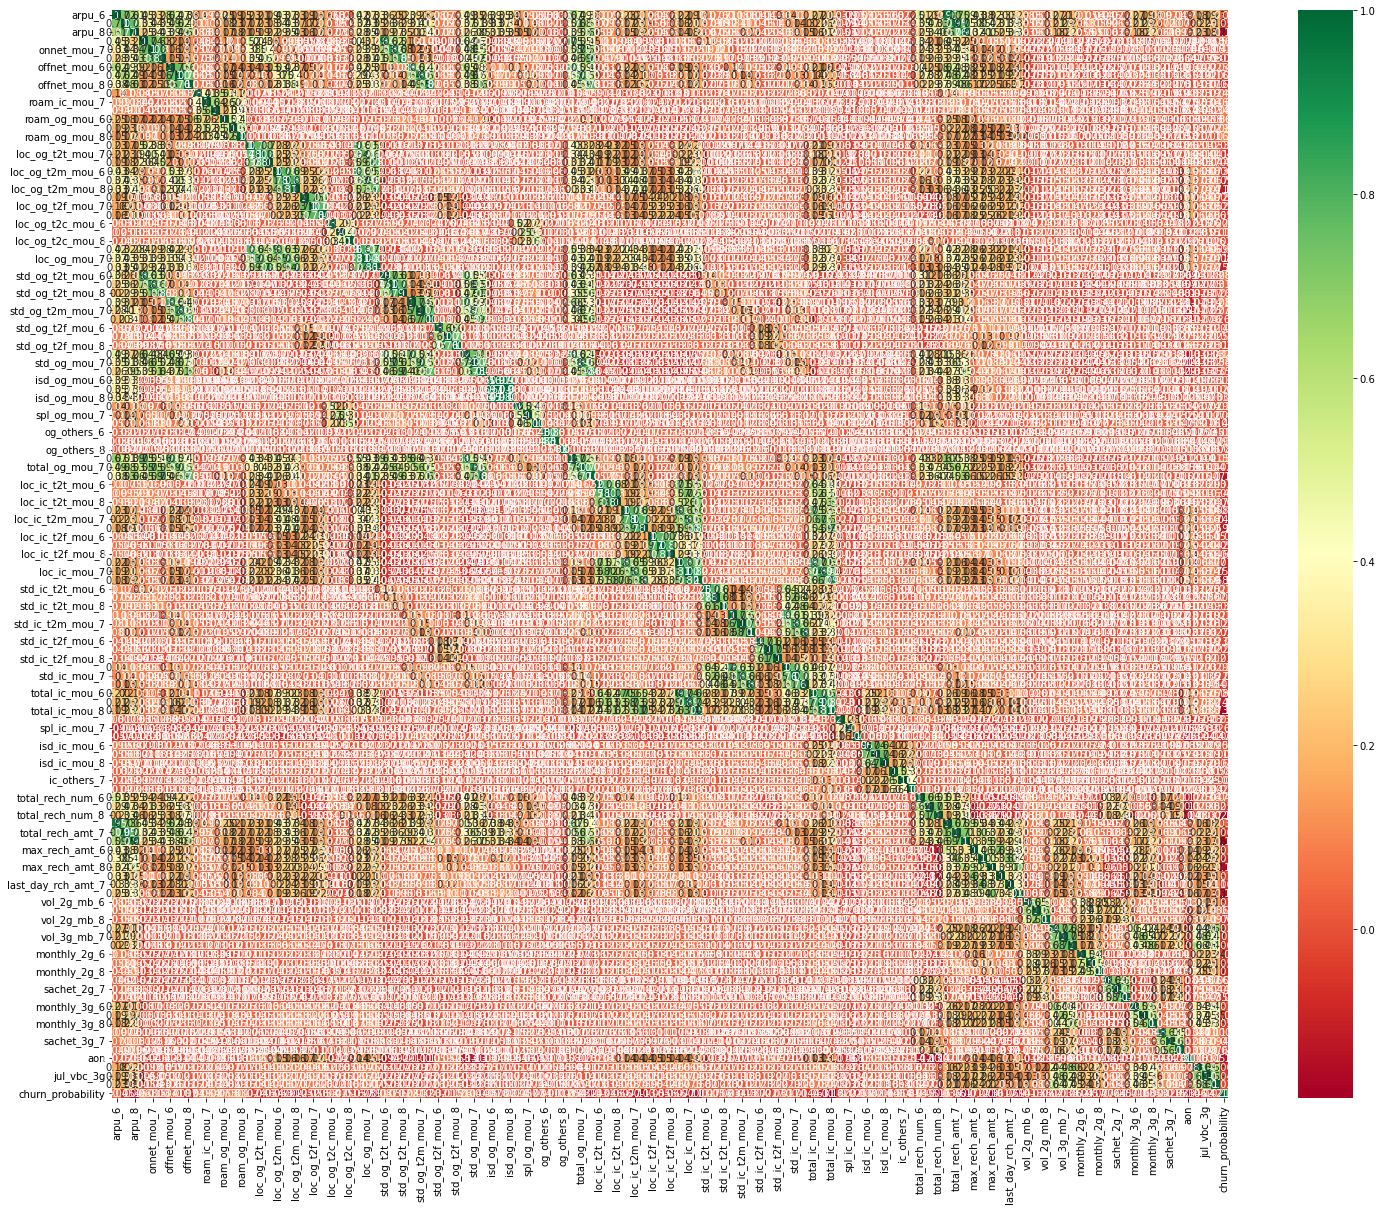

In [37]:
# plot correlation
plt.figure(figsize = (25,20))
sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
plt.show()

In [44]:
cor_matrix = telecom.corr().abs()
print(cor_matrix)
# Note that Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. 
# So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)
# selecting columns that have corr > 0.9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

# Inference
# - before dropping rech columns, let us derive some metrics from the rech columns

                     arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
arpu_6             1.000000  0.716991  0.610834     0.447038     0.331945   
arpu_7             0.716991  1.000000  0.765798     0.326316     0.440663   
arpu_8             0.610834  0.765798  1.000000     0.253124     0.342452   
onnet_mou_6        0.447038  0.326316  0.253124     1.000000     0.742801   
onnet_mou_7        0.331945  0.440663  0.342452     0.742801     1.000000   
...                     ...       ...       ...          ...          ...   
aon                0.025794  0.022872  0.035770     0.046688     0.046354   
aug_vbc_3g         0.176146  0.202521  0.229929     0.009310     0.001772   
jul_vbc_3g         0.193311  0.229050  0.178563     0.006843     0.000031   
jun_vbc_3g         0.225079  0.180867  0.165512     0.005833     0.004266   
churn_probability  0.039579  0.053914  0.158889     0.067801     0.015002   

                   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \

Derive Total recharge amount

In [45]:
rech_col = [col for col in telecom.columns if 'rech' in col]
rech_col



['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8']